In [1]:
import torch
import torch.distributions as dist

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Linear regression with polynomial features and parameter estimation

Demo for lecture.

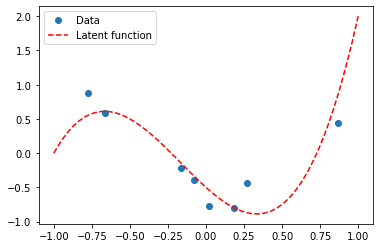

In [2]:
def phi(x, degree):
    """ Generate polynomial features """
    return torch.stack([x**k for k in range(1+degree)], -1)

## New synthetic dataset

np.random.seed(1709)
N_samples = 8
x = torch.FloatTensor(np.concatenate((np.random.rand(N_samples//2), -np.random.rand(N_samples//2))))
true_w = torch.FloatTensor([-0.5, -2.0, 1.5, 3.0])
noiseless_f = lambda x: phi(x, 3) @ true_w
y = noiseless_f(x) + 0.25*torch.FloatTensor(np.random.randn(*x.shape))

plt.plot(x, y, '.', markersize=12)
# plt.legend(["Data", "Latent function"]);
plt.plot(np.linspace(-1,1,50), noiseless_f(torch.linspace(-1,1,50)), 'r--')
plt.legend(["Data", "Latent function"]);

In [3]:
def log_p(Phi, y, w, alpha, beta):
    """ Returns log p(y, w | alpha, beta, x, K) for a fixed feature map.
    
        Allows passing multiple samples as a batch. """
    N, D = Phi.shape
    lp_w = dist.MultivariateNormal(torch.zeros(D), torch.eye(D)/alpha).log_prob(w)
    lp_y = dist.Normal(torch.matmul(Phi, w.unsqueeze(-1)).squeeze(-1), 1.0/beta.sqrt()).log_prob(y).sum(-1)
    return lp_w + lp_y

In [4]:
def get_q_dist(params):
    mu, L = params
    q_w = dist.MultivariateNormal(mu, L.tril() @ L.tril().T + 0.01 * torch.eye(L.shape[0]))
    return q_w


## Estimate parameters by gradient descent

In [5]:
Phi = phi(x, 3)

log_alpha = torch.tensor(1e-4).log().requires_grad_(True)
log_beta = torch.tensor(10.0).log().requires_grad_(True)

init = torch.linalg.inv(Phi.T @ Phi + log_alpha.detach().exp()*torch.eye(Phi.shape[1])) @ (Phi.T @ y)
params = [torch.FloatTensor(init).requires_grad_(True),
          (0.1*torch.randn(Phi.shape[1],Phi.shape[1])).requires_grad_(True)]
del init

opt = torch.optim.Adagrad(params + [log_alpha, log_beta], lr=0.1)

In [6]:


losses = []

for _ in range(5000):
    opt.zero_grad()
    w = torch.randn(4, Phi.shape[1])
    q_w = get_q_dist(params) 
    N_samples = 100
    w = q_w.rsample((N_samples,))
    ELBO = log_p(Phi, y, w, log_alpha.exp(), log_beta.exp()) - q_w.log_prob(w)
    loss = -ELBO.mean()
    loss.backward()
    losses.append(loss.item())
    opt.step()

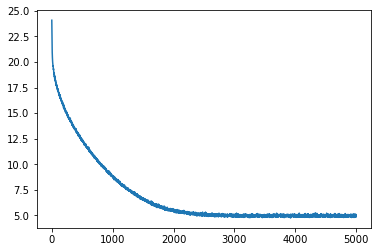

In [7]:

plt.plot(losses)

## Look at the posterior

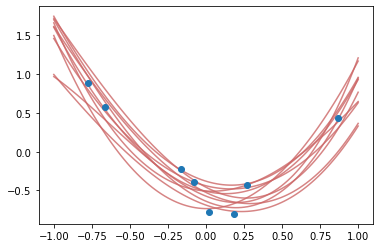

In [8]:
w = q_w.sample((10,))

domain = torch.linspace(-1, 1, 100)
plt.plot(domain, (phi(domain, 3) @ w.T), '-', color='#cc6666', alpha=0.8)

plt.plot(x, y, '.', markersize=12);

In [9]:
print("Prior sd: %0.4f" % (1.0/(0.5*log_alpha.detach()).exp().item()))

Prior sd: 1.0458


In [10]:
print("Likelihood sd: %0.4f" % (1.0/(0.5*log_beta.detach()).exp().item()))

Likelihood sd: 0.2083


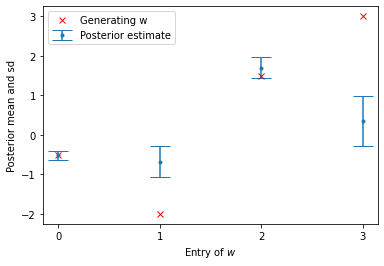

In [11]:
with torch.no_grad():
    plt.errorbar(np.arange(4), q_w.mean.numpy(), yerr=q_w.covariance_matrix.diag().sqrt(), fmt='.', capsize=10);
    plt.xticks(np.arange(4))
    plt.xlabel('Entry of $w$');
    plt.ylabel("Posterior mean and sd")
    plt.plot(true_w, 'rx')
    
plt.legend(['Generating w', 'Posterior estimate']);

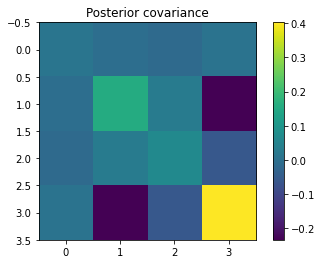

In [12]:
plt.title("Posterior covariance");
plt.imshow(q_w.covariance_matrix.detach())
plt.colorbar();